In [16]:
import os
import torch.nn as nn
import torch.optim as optim
import torchvision
# import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
from src.model import MalConv
from PIL import Image
import torch
import numpy as np
import os
from torchvision import transforms


learning_rate = 0.001
max_step = 100 #This specifies how many times the model will go through the entire training dataset, 
# adjusting weights each time. It is the number of epochs for training, where each epoch represents one full pass through the dataset.

test_step = 10 #This hyperparameter specifies how often you want to test/validate the model on the validation dataset during training.
batch_size = 1
first_n_byte = 900000
SUPERIMPOSITION_FACTOR = 0.5
window_size = 50 #This determines the size of the chunks of data that the convolutional layers in the MalConv model will process at a time. 
# A smaller window size would focus on finer local patterns, while a larger window size might capture broader features.
display_step = 10 # interval at which it will print

In [11]:
def load_executable(file_path):
    try:
        with open(file_path, 'rb') as f:
            tmp = [i + 1 for i in f.read()[:first_n_byte]]
            tmp += [0] * (first_n_byte - len(tmp))  # Pad with zeros if needed

        return np.array(tmp)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

In [12]:
def predict(file_name,malconv,device):
    exe_input = load_executable(file_name)

    if exe_input is not None:
        # Convert input to tensor and move to device
        exe_input_tensor = torch.tensor(exe_input).unsqueeze(
            0).to(device)  # Add batch dimension

        # Forward pass to get prediction
        with torch.no_grad():  # Disable gradient calculation for testing
            pred = malconv(exe_input_tensor.long())

        prediction = torch.sigmoid(pred).cpu().numpy()
        print(f"Prediction for {file_name}: {prediction[0][0]:.6f}")
    else:
        print("Failed to load the executable file.")
        return -1
    return prediction

In [13]:
def convert_to_image(file_path, output_path):
    with open(file_path, 'rb') as f:
        binary_data = f.read()
    
    # Convert binary data to a numpy array
    data = np.frombuffer(binary_data, dtype=np.uint8)
    total_pixels = len(data)
    
    # Define the target image dimensions
    height = 1000
    width = 900
    required_pixels = height * width
    
    print(f"Total bytes read: {total_pixels}, Required pixels: {required_pixels}")
    
    # Pad or trim the data to fit the required size
    if total_pixels < required_pixels:
        padding_size = required_pixels - total_pixels
        padded_data = np.pad(data, (0, padding_size), mode='constant')
        data = padded_data
    elif total_pixels > required_pixels:
        data = data[:required_pixels]  # Trim excess data
    
    # Reshape and save as an image
    image = data.reshape((height, width))
    image_pil = Image.fromarray(image.astype(np.uint8), mode='L')  # 'L' mode for grayscale
    image_pil.save(output_path)

In [9]:
transform = transforms.Compose([
    transforms.Resize((1000, 900)),           # Resize to 900x1000
    transforms.ToTensor(),                     # Convert to tensor
    # Normalize for grayscale (single channel)
    transforms.Normalize((0.5,), (0.5,))
])

In [19]:
golucount  = 0
misclasified_files = 0

In [25]:

def test_generator(generator, classifier, malware_file, device='cuda', original_length=20):
    """
    Test the generator by generating an adversarial image from a grayscale input image.

    Args:
        generator (torch.nn.Module): The adversarial generator model.
        classifier (torch.nn.Module): The classifier model (e.g., MalConv).Prediction for malconv/train/mal/1885: 0.262249
Prediction for Playground/output.bin: 0.969424
        malware_file (str): Path to the malware file (used for predicting).
        device (str): Device to run the model on ('cuda' or 'cpu').
        original_length (int): The original length of the executable data.

    Returns:
        image_tensor (torch.Tensor): The original image tensor.
        adversarial_image (torch.Tensor): The adversarial image generated.
    """
    # Convert malware file to image (using the convert_to_image function, assumed to exist)
    url = "Playground/input/"
    url1 = "Playground/outputimg/"
    url2 = "Playground/outputexe/"
    os.makedirs(url, exist_ok=True)
    os.makedirs(url1, exist_ok=True)
    os.makedirs(url2, exist_ok=True)

    convert_to_image(malware_file, url+f"{golucount}.png")  # Assuming you have a function to convert malware to an image

    # Open image in grayscale mode ('L')
    image = Image.open(url+f"{golucount}.png").convert('L')  # Ensure grayscale

    # Apply transformations (e.g., resizing and converting to tensor)
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Generate adversarial image
    generator.eval()
    with torch.no_grad():
        adversarial_image = generator(image_tensor)

        # Denormalize the generated image
        def denormalize(tensor):
            tensor = tensor.squeeze(0)  # Remove batch dimension
            tensor = tensor * 0.5 + 0.5  # Denormalize the pixel values
            return tensor.clamp(0, 1)  # Clamp values to [0, 1]

        adversarial_img = transforms.ToPILImage()(denormalize(adversarial_image))
        adversarial_img.save(url1+f"{golucount}.png")  # Save adversarial image

        # Get predictions for original and adversarial images
        original_pred = predict(malware_file, classifier, 'cpu')

        # Reopen the adversarial image for binary conversion
        image = Image.open(url1+f"{golucount}.png").convert('L')  # Ensure it's in grayscale  
        flat_data = np.array(image).flatten().astype(np.uint8)

        # Trim data to match the original length
        exe_data = flat_data[:original_length]

        # Write binary data to output EXE file
        with open(url2+f"{golucount}", 'wb') as exe_file:
            exe_file.write(exe_data)

        # Get prediction for the adversarial example
        adversarial_pred = predict(url2+f"{golucount}", classifier, 'cpu')

        # print(f'Original prediction: {original_pred}')
        # print(f'Adversarial prediction: {adversarial_pred}')
        with open ("output_text_file.txt","w") as f:
            f.write(str(original_pred))
            f.write(str(adversarial_pred)+"\n")

        # Calculate perturbation magnitudemodified
        perturbation = adversarial_image - image_tensor
        perturbation_magnitude = torch.norm(perturbation)
        # print(f'Perturbation magnitude: {perturbation_magnitude.item():.4f}')
        global misclasified_files
        if adversarial_pred < 0.5:
            misclasified_files+=1

    return image_tensor, adversarial_image


In [15]:
class Generator(nn.Module):
    def __init__(self, image_channels=1):  # Set image_channels to 1 for grayscale
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Downsampling to 450x500
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Further downsampling to 225x250
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # Downsampling to 112x125
        )
# 2. Noise Generator:
# After extracting features from the image using the encoder, the model then generates some form of "noise" based on those features. 
# This part is essentially a series of convolution layers that reduce the depth of the feature maps back down to the number of image channels (
# 1 in your case for grayscale images):
        # Noise generator
        self.noise_generator = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, image_channels, kernel_size=3, padding=1),
            nn.Tanh()  # Output small perturbations
        )

        # Upsampling layer to match original input sizeThe upsampling is done using bilinear interpolation, 
        # which is a method of rescaling an image based on linear interpolation between neighboring pixel values. 
        # This mode works well for continuous data (like image data) and smooths out the upscaled output.


        self.upsample = nn.Upsample(
            size=(1000, 900), mode='bilinear', align_corners=True
        )

    def forward(self, x):
        features = self.encoder(x)
        noise = self.noise_generator(features)

        # Upsample noise to match original input size (900x1000)
        noise_upsampled = self.upsample(noise)

        return x + SUPERIMPOSITION_FACTOR*noise_upsampled  # Now both tensors should have matching dimensions


In [37]:
gen = Generator()
classif = MalConv(input_length=first_n_byte, window_size=window_size)


list_of_models = ["adversarial_generator_malware1.pth","adversarial_generator_malware2.pth","adversarial_generator_malware_sup_factor_0.8_epoch_2.pth","adversarial_generator_malware_sup_factor_0.8_epoch_1.pth","adversarial_generator_malware_sup_factor_0.5_epoch_1.pth","adversarial_generator_malware_sup_factor_0.5_epoch_2.pth"]
list_of_models.sort()
# gen.load_state_dict(torch.load("adversarial_generator_malware1.pth"))
classif.load_state_dict(torch.load('malconv_model_10 steps.pth'))
# gen.eval()
classif.eval()

/tmp/ipykernel_19086/2870067001.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classif.load_state_dict(torch.load('malconv_model_10 steps.pth'))


MalConv(
  (embed): Embedding(257, 8, padding_idx=0)
  (conv_1): Conv1d(4, 128, kernel_size=(50,), stride=(50,))
  (conv_2): Conv1d(4, 128, kernel_size=(50,), stride=(50,))
  (pooling): MaxPool1d(kernel_size=18000, stride=18000, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [29]:
def log_model_accuracy(model_name, accuracy, log_file='model_accuracy.txt'):
    with open(log_file, 'a') as file:
        file.write(f"Model: {model_name}, Accuracy: {accuracy}\n")

In [38]:
print(list_of_models)

['adversarial_generator_malware1.pth', 'adversarial_generator_malware2.pth', 'adversarial_generator_malware_sup_factor_0.5_epoch_1.pth', 'adversarial_generator_malware_sup_factor_0.5_epoch_2.pth', 'adversarial_generator_malware_sup_factor_0.8_epoch_1.pth', 'adversarial_generator_malware_sup_factor_0.8_epoch_2.pth']


In [ ]:
malware_files = os.listdir("malconv/test/mal")
total_number_of_malwares = len(malware_files)
print("Number of files in the test directory is ",total_number_of_malwares)
for j in list_of_models:
    gen.load_state_dict(torch.load(j))
    gen.eval()
    for i in malware_files:
        test_generator(gen,classif,"malconv/test/mal/"+i,'cpu',os.path.getsize("malconv/test/mal/"+i))
        golucount+=1
        


    log_model_accuracy(j,misclasified_files/golucount)
    golucount = 0
    misclasified_files = 0

Number of files in the test directory is  3000
Total bytes read: 524856, Required pixels: 900000


/tmp/ipykernel_19086/1902416657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load(j))


Prediction for malconv/test/mal/12495: 0.784986
Prediction for Playground/outputexe/0: 0.136127
Total bytes read: 328192, Required pixels: 900000


/tmp/ipykernel_19086/2967177869.py:52: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  flat_data = np.array(image).flatten().astype(np.uint8)


Prediction for malconv/test/mal/15906: 0.989085
Prediction for Playground/outputexe/1: 0.257590
Total bytes read: 668746, Required pixels: 900000
Prediction for malconv/test/mal/132599: 0.227196
Prediction for Playground/outputexe/2: 0.065106
Total bytes read: 229376, Required pixels: 900000
Prediction for malconv/test/mal/13605: 0.769554
Prediction for Playground/outputexe/3: 0.163708
Total bytes read: 680581, Required pixels: 900000
Prediction for malconv/test/mal/107886: 0.988131
Prediction for Playground/outputexe/4: 0.044943
Total bytes read: 247480, Required pixels: 900000
Prediction for malconv/test/mal/115205: 0.962803
Prediction for Playground/outputexe/5: 0.182824
Total bytes read: 114796, Required pixels: 900000
Prediction for malconv/test/mal/17044: 0.253597
Prediction for Playground/outputexe/6: 0.048878
Total bytes read: 827457, Required pixels: 900000
Prediction for malconv/test/mal/11314: 0.164294
Prediction for Playground/outputexe/7: 0.092415
Total bytes read: 256869,

In [39]:
print(golucount,misclasified_files)

0 0


### Testing Classifier

In [42]:
cnt = 0
for i in malware_files:
    original_pred = predict("malconv/test/mal/"+i, classif, 'cpu')
    if original_pred > 0.5:
        cnt+=1
print(cnt)



Prediction for malconv/test/mal/12495: 0.784986
Prediction for malconv/test/mal/15906: 0.989085
Prediction for malconv/test/mal/132599: 0.227196
Prediction for malconv/test/mal/13605: 0.769554
Prediction for malconv/test/mal/107886: 0.988131
Prediction for malconv/test/mal/115205: 0.962803
Prediction for malconv/test/mal/17044: 0.253597
Prediction for malconv/test/mal/11314: 0.164294
Prediction for malconv/test/mal/114857: 0.999495
Prediction for malconv/test/mal/105945: 0.997584
Prediction for malconv/test/mal/13839: 0.618872
Prediction for malconv/test/mal/107395: 0.999530
Prediction for malconv/test/mal/513063: 0.916592
Prediction for malconv/test/mal/182603: 0.228913
Prediction for malconv/test/mal/100887: 0.999530
Prediction for malconv/test/mal/99906: 0.901642
Prediction for malconv/test/mal/16446: 0.973225
Prediction for malconv/test/mal/123811: 0.970206
Prediction for malconv/test/mal/26628: 0.171895
Prediction for malconv/test/mal/15095: 0.553042
Prediction for malconv/test/ma

In [44]:
benFiles  = os.listdir("malconv/test/ben")
cnt1 = 0
for i in benFiles:
    original_pred = predict("malconv/test/ben/"+i, classif, 'cpu')
    if original_pred < 0.5:
        cnt1+=1
print(cnt1+cnt)

Prediction for malconv/test/ben/207412: 0.123393
Prediction for malconv/test/ben/209319: 0.030569
Prediction for malconv/test/ben/195360: 0.006675
Prediction for malconv/test/ben/233666: 0.039899
Prediction for malconv/test/ben/241238: 0.049630
Prediction for malconv/test/ben/194269: 0.047351
Prediction for malconv/test/ben/246156: 0.047783
Prediction for malconv/test/ben/233503: 0.292423
Prediction for malconv/test/ben/194141: 0.005682
Prediction for malconv/test/ben/211026: 0.050769
Prediction for malconv/test/ben/244548: 0.035248
Prediction for malconv/test/ben/191824: 0.009485
Prediction for malconv/test/ben/183229: 0.377636
Prediction for malconv/test/ben/200800: 0.143986
Prediction for malconv/test/ben/201169: 0.171652
Prediction for malconv/test/ben/214224: 0.053356
Prediction for malconv/test/ben/225326: 0.008275
Prediction for malconv/test/ben/210131: 0.050018
Prediction for malconv/test/ben/253922: 0.251395
Prediction for malconv/test/ben/212686: 0.141240
Prediction for malco

In [45]:
print(cnt1/total_number_of_malwares)

0.977


In [41]:
gen.load_state_dict(torch.load("adversarial_generator_malware1.pth"))
gen.eval()
for i in malware_files:
        test_generator(gen,classif,"malconv/test/mal/"+i,'cpu',os.path.getsize("malconv/test/mal/"+i))
        golucount+=1

log_model_accuracy("adversarial_generator_malware1.pth",misclasified_files/golucount)

/tmp/ipykernel_19086/2671644829.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load("adversarial_generator_malware1.pth"))


Total bytes read: 524856, Required pixels: 900000
Prediction for malconv/test/mal/12495: 0.784986
Prediction for Playground/outputexe/0: 0.136127
Total bytes read: 328192, Required pixels: 900000


/tmp/ipykernel_19086/2967177869.py:52: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  flat_data = np.array(image).flatten().astype(np.uint8)


Prediction for malconv/test/mal/15906: 0.989085
Prediction for Playground/outputexe/1: 0.257590
Total bytes read: 668746, Required pixels: 900000
Prediction for malconv/test/mal/132599: 0.227196
Prediction for Playground/outputexe/2: 0.065106
Total bytes read: 229376, Required pixels: 900000
Prediction for malconv/test/mal/13605: 0.769554
Prediction for Playground/outputexe/3: 0.163708
Total bytes read: 680581, Required pixels: 900000
Prediction for malconv/test/mal/107886: 0.988131
Prediction for Playground/outputexe/4: 0.044943
Total bytes read: 247480, Required pixels: 900000
Prediction for malconv/test/mal/115205: 0.962803
Prediction for Playground/outputexe/5: 0.182824
Total bytes read: 114796, Required pixels: 900000
Prediction for malconv/test/mal/17044: 0.253597
Prediction for Playground/outputexe/6: 0.048878
Total bytes read: 827457, Required pixels: 900000
Prediction for malconv/test/mal/11314: 0.164294
Prediction for Playground/outputexe/7: 0.092415
Total bytes read: 256869,

KeyboardInterrupt: 

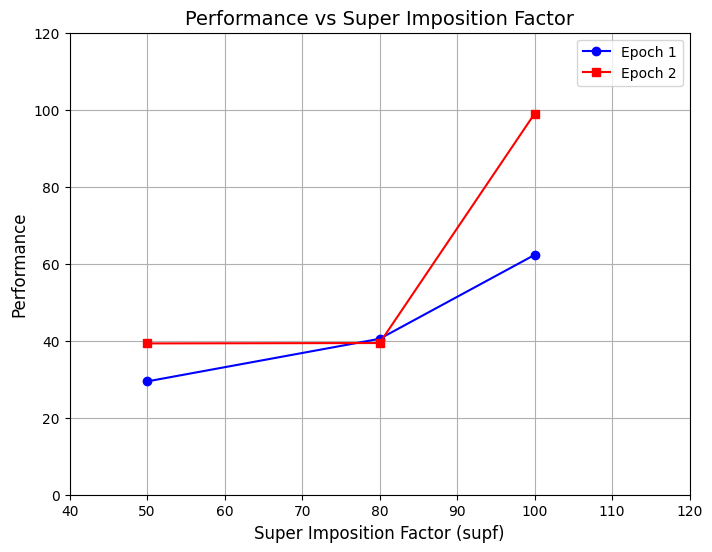

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# Data for plotting
data = """
epoch,supf,performace
1,100,62.3
2,100,99
1,80,40.5
2,80,39.4
1,50,29.43
2,50,39.3
"""

# Read the data into a pandas DataFrame
df = pd.read_csv(StringIO(data))

# Separate the data for each epoch
epoch1_data = df[df['epoch'] == 1]
epoch2_data = df[df['epoch'] == 2]

# Plotting the data
plt.figure(figsize=(8, 6))

# Plot for epoch 1
plt.plot(epoch1_data['supf'], epoch1_data['performace'], label='Epoch 1', marker='o', color='blue')

# Plot for epoch 2
plt.plot(epoch2_data['supf'], epoch2_data['performace'], label='Epoch 2', marker='s', color='red')

# Adding labels and title
plt.xlabel('Super Imposition Factor (supf)', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance vs Super Imposition Factor', fontsize=14)
plt.legend()

# Set the range for both axes
plt.xlim(40, 120)
plt.ylim(0, 120)

# Show the plot
plt.grid(True)
plt.show()
